# **Modelling and Evaluating**

## Objectives

Achieve business requirement no. 2:

* The client is interested to tell wheterh a given leaf is covered with powdery mildew


## Inputs

- image shape embeddings (pickle file)
- Images from the test, train, validation folders and their subfolders. 
    ```bash
    . 
    ├── inputs 
    │   └──cherryleaves_dataset 
    │      └──cherry-leaves                                     
    │           ├── test
    │           │   ├── healthy
    │           │   └── powdery_mildew                   
    │           ├── train
    │           │   ├── healthy
    │           │   └── powdery_mildew          
    │           └── validation
    │               ├── healthy
    │               └── powdery_mildew                 
    └── ...
    ```

## Output

* Distribution plot of images in the training, validation, and test sets.

    * Label distribution - bar chart
    * Set distribution - pie chart (percentages)

* Image augmentation.

    * Display augmented images for each set.

* Class indices to modify prediction inference in labels.
* Development of a machine learning model and presentation of its summary.
* Training the model.
* Saving the model.
* Learning curve plot for model performance.

    * Model A - separate plots for accuracy and loss
    * Model B - overall model history plot
    * Model C - model history plot using Plotly

* Evaluation of the model on the saved file.

    * Calculate accuracy
    * Plot ROC curve
    * Generate classification report (Model A)
        * Model B - classification report with macro average and weighted average
        * Model C - synthetic classification report for each label

* Plot confusion matrix
* Save evaluation as a pickle file
* Make predictions on a random image file.

## Comments 

* The same data was visualized in various formats to address potential client requests for deeper insights. 
* The CNN was developed with the goal of maximizing accuracy while minimizing loss and training duration. 

## Import regular packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import tensorflow as tf
from matplotlib.image import imread

## Set working directory

In [2]:
current_dir = os.getcwd()
os.chdir(os.path.dirname(current_dir))
work_dir = os.getcwd()
work_dir

'/workspace/mildew-leaves-detection'

In [3]:
work_dir = os.getcwd()
work_dir

'/workspace/mildew-leaves-detection'

## Set input directories

Set train, validation and test paths

In [4]:
my_data_dir = 'inputs/cherryleaves_dataset/cherry-leaves'
train_path = my_data_dir + '/train' 
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Set output directory

In [5]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


## Set labels

In [6]:
labels = os.listdir(train_path)
print('Label for the images are', labels)

Label for the images are ['healthy', 'powdery_mildew']


## Set image shape

In [7]:
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
print(f"Input image shape: Width:({image_shape[0]}), Height:({image_shape[1]}), Channels:({image_shape[2]})")
image_shape

Input image shape: Width:(256), Height:(256), Channels:(3)


(256, 256, 3)

---

## Distribution of Images Across Datasets

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images




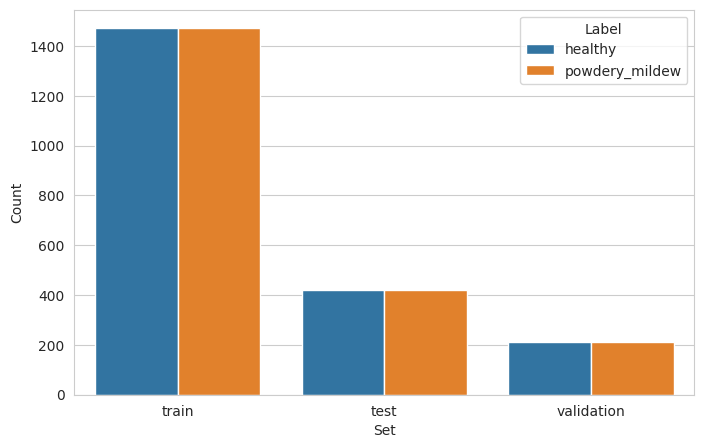

In [8]:
import plotly.express as px

df_freq = pd.DataFrame([])
for folder in ['train', 'test', 'validation']:
    for label in labels:
        df_freq = df_freq.append(
            pd.Series(data={'Set': folder,
                            'Label': label,
                            'Count': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))}
                      ),
            ignore_index=True
        )

        print(
            f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Count', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()

## Image Data Preparation and Augmentation

### Import ImageDataGenerator

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Initialize ImageDataGenerator

In [10]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

### Image data augmentation


In [11]:
batch_size = 32

train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='categorical',
                                                     shuffle=True
                                                     )


validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='categorical',
                                                                        shuffle=False
                                                                        )
                                                                        

test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='categorical',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 2944 images belonging to 2 classes.
Found 420 images belonging to 2 classes.
Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Plot augmented training image set

(32, 256, 256, 3)


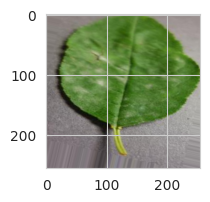

(32, 256, 256, 3)


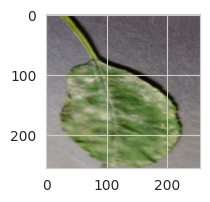

(32, 256, 256, 3)


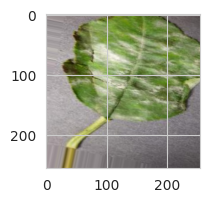

In [12]:
%matplotlib inline
for _ in range(3):
    plt.figure(figsize=(2, 2))
    img, label = train_set.next()
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()

### Plot augmented validation image set

(32, 256, 256, 3)


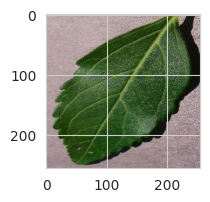

(32, 256, 256, 3)


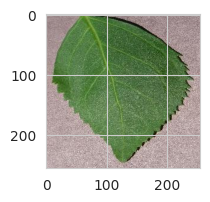

(32, 256, 256, 3)


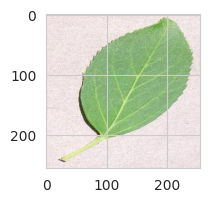

In [13]:
for _ in range(3):
    plt.figure(figsize=(2, 2))
    img, label = validation_set.next()
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()

### Plot augmented test image set

(32, 256, 256, 3)


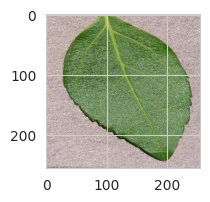

(32, 256, 256, 3)


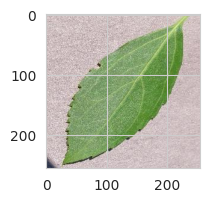

(32, 256, 256, 3)


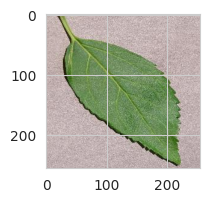

In [14]:
for _ in range(3):
    plt.figure(figsize=(2, 2))
    img, label = test_set.next()
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()

### Save class_indices

In [15]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

---

## Model Creation

### Import packages

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import RMSprop, Adam, Adagrad

### Model

In [17]:
def create_tf_model():
    model = Sequential()

    ### input layer
    model.add(Conv2D(32, (3, 3), input_shape=image_shape, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    ### convolutional layers
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))      
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    
    ### fully connected layer
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(.2))

    ### output
    model.add(Dense(2, activation='softmax')) 

    model.compile(loss='categorical_crossentropy', 
                  optimizer='adagrad',
                  metrics=['accuracy'])

    return model

### Model Summary

In [18]:
create_tf_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 57600)             0

2024-11-03 10:21:38.240359: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Early Stopping

In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_accuracy',mode='max',verbose=1, patience=2)
m_checkpoint = ModelCheckpoint(filepath='outputs/v1/powdery_mildew_model.h5', monitor='val_accuracy', mode='max', save_best_only=True)



### Fit model for model training

In [20]:
model = create_tf_model()
model.fit(train_set,
          batch_size=batch_size,
          epochs=32,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop, m_checkpoint],
          verbose=1
          )

2024-11-03 10:21:38.693320: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/32
 2/92 [..............................] - ETA: 3:17 - loss: 0.7021 - accuracy: 0.4844

92/92 [==============================] - 223s 2s/step - loss: 0.5951 - accuracy: 0.6977 - val_loss: 0.6778 - val_accuracy: 0.5357
Epoch 2/32
92/92 [==============================] - 217s 2s/step - loss: 0.4111 - accuracy: 0.8247 - val_loss: 0.3153 - val_accuracy: 0.8643
Epoch 3/32
92/92 [==============================] - 216s 2s/step - loss: 0.3406 - accuracy: 0.8512 - val_loss: 0.2857 - val_accuracy: 0.8857
Epoch 4/32
92/92 [==============================] - 216s 2s/step - loss: 0.2970 - accuracy: 0.8757 - val_loss: 0.3014 - val_accuracy: 0.8500
Epoch 5/32
92/92 [==============================] - 215s 2s/step - loss: 0.2965 - accuracy: 0.8689 - val_loss: 0.2435 - val_accuracy: 0.8905
Epoch 6/32
92/92 [==============================] - 215s 2s/step - loss: 0.2718 - accuracy: 0.8835 - val_loss: 0.2313 - val_accuracy: 0.8857
Epoch 7/32
92/92 [==============================] - 216s 2s/step - loss: 0.2527 - accuracy: 0.8957 - val_loss: 0.2025 - val_accuracy: 0.9095
Epoch 8/32
92/92 [======

### Save model

In [21]:
from keras.models import load_model

load_model('outputs/v1/powdery_mildew_model.h5')

---

## Model Performance

### Model learining curve

<Figure size 500x400 with 0 Axes>

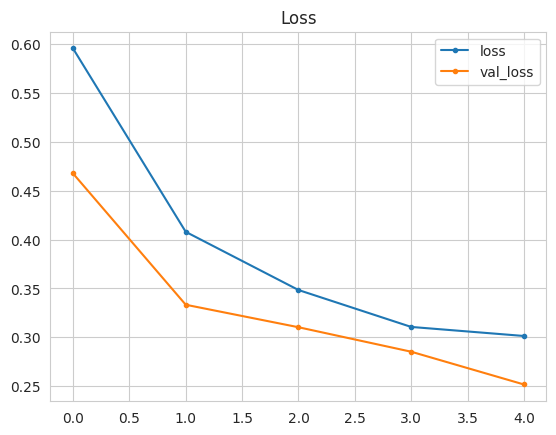

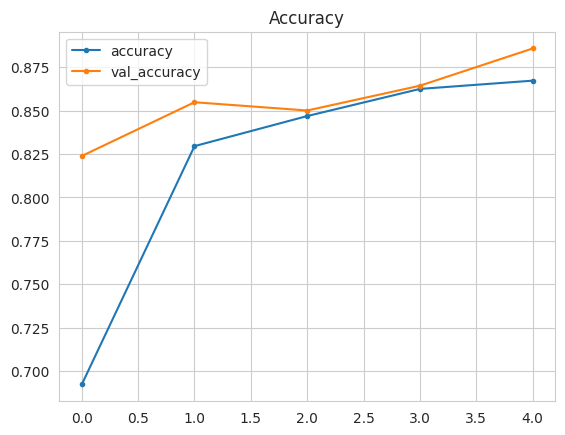

In [38]:
losses = pd.DataFrame(model.history.history)
plt.figure(figsize=(5, 4))
sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")

plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")

plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)

plt.show()

---

## Model Evaluation

### Import packages

In [39]:
import sklearn
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

### Load saved model

In [40]:
from keras.models import load_model
model = load_model('outputs/v1/powdery_mildew_model.h5')

### Evaluation of the model on the test set

In [41]:
evaluation = model.evaluate(test_set, batch_size=batch_size)
print("Model accuracy: {:.2f}%".format(evaluation[1] * 100))
print("Model Loss: ",evaluation[0])

27/27 [==============================] - 15s 558ms/step - loss: 0.2398 - accuracy: 0.8981
Model accuracy: 89.81%
Model Loss:  0.23975661396980286


### Save evaluation pickle

In [42]:
joblib.dump(value=evaluation,
            filename=f"outputs/v1/evaluation.pkl")

['outputs/v1/evaluation.pkl']

---

### Predict on new data

Load a random image as PIL

Image shape: (256, 256), Image mode: RGB


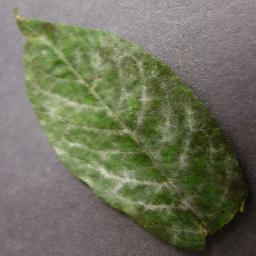

In [43]:
from tensorflow.keras.preprocessing import image

pointer = 32
label = labels[1] # select 0 for 'healthy' or 1 for 'powdery_mildew'

pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer],
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

### Convert image to array and prepare for prediction

In [45]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 256, 256, 3)


### Predict class probabilities

In [46]:
pred_proba = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba < 0.5]

if pred_class == target_map[1]:
    pred_proba = 1 - pred_proba

print(f"{pred_class} {round(pred_proba*100, 2)}%")

powdery_mildew 98.51%
